In [24]:
import pykerrp2p as rt

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.sans-serif": ["Helvetica"],
    "axes.prop_cycle": plt.cycler('color', ['k', 'r', 'b', 'g'])})

In [25]:
def rc_range(a): 
    return (4 * np.square(np.cos(np.arccos(-a) / 3) + 1e-10), 4 * np.square(np.cos(np.arccos(a) / 3)) - 1e-10)

def sign_to_num(x):
    if x == rt.Sign.POSITIVE: return +1
    elif x == rt.Sign.NEGATIVE: return -1
    else: return np.nan
        
def conserve_to_ob(a, lam, eta, theta_o, nu_theta_o): ## nu_theta_o takes number +1 or -1
    alpha = -lam / np.sin(theta_o)
    beta = nu_theta_o * np.sqrt(eta + a**2 * np.cos(theta_o)**2 - lam**2 / np.tan(theta_o)**2)
    return float(alpha), float(beta)

# Basic Usages

In [26]:
"""set parameters"""
print("Notice that we fixed phi_s = 0 in this code for simplicity.")
params = rt.ForwardRayTracingParams()
params.a = 0.8
params.r_s = 10
params.theta_s = 89.9 * np.pi / 180
params.nu_r = rt.Sign.NEGATIVE
params.nu_theta = rt.Sign.NEGATIVE
params.r_o = 1000

Notice that we fixed phi_s = 0 in this code for simplicity.


In [27]:
"""calculate the final direction of a ray given source position and (rc,d)"""
params.rc = 3.2
params.log_abs_d = -0.5  ## 'log' takes 10 as the base
params.d_sign = rt.Sign.POSITIVE
params.calc_t_f = True
params.rc_d_to_lambda_q()
res = rt.calc_ray(params)

print("%13s" % "lam, eta, q: ",(params.lam, params.q**2, params.q),"\n")
print("%13s" % "state: ", res.ray_status)
print("%13s" % "theta_f: ", res.theta_f)
print("%13s" % "phi_f: ", res.phi_f)
print("%13s" % "t_f: ", res.t_f)
print("%13s" % "n: ", res.n_half)

lam, eta, q:  (-2.761619769027747, 28.94863977029794, 5.3803940162685056) 

      state:  RayStatus.NORMAL
    theta_f:  2.5403569818528107
      phi_f:  -4.977691330899611
        t_f:  1038.0260558523923
          n:  1.622843009206923


In [28]:
"""impact parameters of the image"""
nu_theta_o = sign_to_num(params.nu_theta) * (-1)**res.m
print(nu_theta_o)
print("alpha, beta: ", conserve_to_ob(params.a, params.lam, params.q**2, res.theta_f, nu_theta_o))

-1
alpha, beta:  (4.882103315761093, -3.629802718731984)


In [29]:
"""find_root: treat phi and phi + 2pi as equivalent"""

theta_target = 2.5
phi_target_normalized = -5.0 % (2*np.pi)
phi_target_normalized

1.2831853071795862

In [30]:
tol = 1e-7 ## residue tolerance 
res2 = rt.find_root(params, theta_target, phi_target_normalized, tol)

print("success = ", res2.success)
if res2.success:
    root = res2.root
    print("%13s" % "rc, log_abs_d: ", (root.rc, root.log_abs_d))
    print("%13s" % "lam, eta, q: ", (root.lam, root.eta, float(np.sqrt(root.eta))),"\n")
    print("%13s" % "state: ", root.ray_status)
    print("%13s" % "theta_f: ", root.theta_f)
    print("%13s" % "phi_f: ", root.phi_f)
    print("%13s" % "t_f: ", root.t_f)
    print("%13s" % "n: ", root.n_half)
else:
    print("fail reason: ", res2.fail_reason)

success =  True
rc, log_abs_d:  (3.223886426223728, -0.5195408229504943)
lam, eta, q:  (-2.903346700092525, 28.424123502261256, 5.331427904629421) 

      state:  RayStatus.NORMAL
    theta_f:  2.4999999999998272
      phi_f:  -4.999999999999135
        t_f:  1038.2372863273404
          n:  1.6347046768090736


In [31]:
"""find_root_period: specify a period number of phi"""

theta_target = 2.5
phi_target_normalized = -5.0 % (2*np.pi)
period = int(np.floor(-5.0 / (2 * np.pi)))
(phi_target_normalized, period)

(1.2831853071795862, -1)

In [32]:
tol = 1e-7 ## residue tolerance 
res3 = rt.find_root_period(params, period, theta_target, phi_target_normalized, tol)

print("success = ", res3.success)
if res3.success:
    root = res3.root
    print("%13s" % "rc, log_abs_d: ", (root.rc, root.log_abs_d))
    print("%13s" % "lam, eta, q: ", (root.lam, root.eta, float(np.sqrt(root.eta))),"\n")
    print("%13s" % "state: ", root.ray_status)
    print("%13s" % "theta_f: ", root.theta_f)
    print("%13s" % "phi_f: ", root.phi_f)
    print("%13s" % "t_f: ", root.t_f)
    print("%13s" % "n: ", root.n_half)
else:
    print("fail reason: ", res2.fail_reason)

success =  True
rc, log_abs_d:  (3.2238864262231712, -0.5195408229505831)
lam, eta, q:  (-2.9033467000891164, 28.424123502270007, 5.3314279046302415) 

      state:  RayStatus.NORMAL
    theta_f:  2.500000000000002
      phi_f:  -4.999999999999996
        t_f:  1038.2372863273426
          n:  1.6347046768091915


# Sweep

In [10]:
rc_l, rc_h = rc_range(params.a)
rc_size = 1000
d_size = 1000
rc_list = np.linspace(rc_l, rc_h, rc_size)
lgd_list = np.linspace(-10, 2, d_size)
cutoff = 50
tol = 1e-6

In [11]:
theta_o = 17 * np.pi / 180
phi_o = np.pi / 4
params.d_sign = rt.Sign.POSITIVE
params.print_args_error = False
data = rt.sweep_rc_d_Float64(params, theta_o, phi_o, rc_list, lgd_list, cutoff, tol)

[GIntegral<double, complex<double>>] a = 0.8, r_s = 10, theta_s 1.5690509975429023, r_o = 1000, lambda = 3.05401159843154, eta = 2.1463657233350393, ellint_sin_phi = 1.0000000000207336, 'ellint_sin_phi' out of range


In [12]:
final_params = np.zeros((len(data.results), 5))
for i in range(len(data.results)):
    final_params[i, 0] = data.results[i].rc
    final_params[i, 1] = data.results[i].log_abs_d
    final_params[i, 2] = data.results[i].lam
    final_params[i, 3] = data.results[i].eta
    final_params[i, 4] = data.results[i].n_half
sorted(final_params, key = lambda x: x[4])

[array([ 2.83255652, -1.47028852, -0.75074792, 26.57232166,  2.4168449 ]),
 array([ 2.82249152, -4.13420078, -0.70800103, 26.13866612,  4.5831694 ]),
 array([ 2.50331949, -6.17299803,  0.72371361, 21.06768237,  6.41896414]),
 array([ 2.79625627, -8.80739756, -0.58212865, 25.87628328,  8.41236418])]

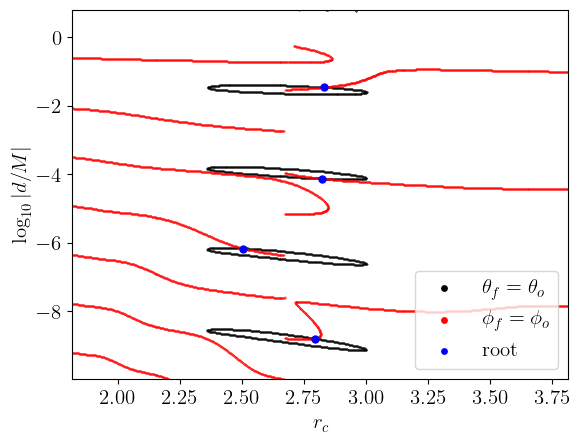

In [13]:
fig, ax = plt.subplots()

ax.scatter(data.theta_roots[:, 0], data.theta_roots[:, 1], s = 0.1, label = r"$\theta_f = \theta_o$")
ax.scatter(data.phi_roots[:, 0], data.phi_roots[:, 1], s = 0.1, label = r"$\phi_f = \phi_o$")
ax.scatter(final_params[:, 0], final_params[:, 1], s = 25, marker = "o", label = r"$\mathrm{root}$")

ax.set_xlabel(r'$r_c$')
ax.set_ylabel(r'$\log_{10}|d/M|$')
ax.set_xmargin(0)
ax.set_ymargin(0)

for item in [ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels():
  item.set_fontsize(15)

legend = ax.legend(fontsize=15, loc=4)
for legend_handle in legend.legend_handles:
    legend_handle.set_sizes([15])

#fig.savefig("test.png", bbox_inches='tight', dpi=1200)

# Explore all sign combinations

<>:71: SyntaxWarning: invalid escape sequence '\ '
<>:71: SyntaxWarning: invalid escape sequence '\ '
<>:71: SyntaxWarning: invalid escape sequence '\ '
<>:71: SyntaxWarning: invalid escape sequence '\ '
/var/folders/83/5z4lbxmx51j1qdcs67274ntc0000gn/T/ipykernel_4171/2277490818.py:71: SyntaxWarning: invalid escape sequence '\ '
  ax.set_title(r"$(\nu_r^s,\ \nu_{\theta}^s,\ \mathrm{sign}(d)) = ($"+ sign_to_num_label(val_nu_r) +"$,\ $"+ sign_to_num_label(val_nu_theta) + "$,\ $" + sign_to_num_label(val_d_sign) +"$)$", pad=15, fontsize = 17)
/var/folders/83/5z4lbxmx51j1qdcs67274ntc0000gn/T/ipykernel_4171/2277490818.py:71: SyntaxWarning: invalid escape sequence '\ '
  ax.set_title(r"$(\nu_r^s,\ \nu_{\theta}^s,\ \mathrm{sign}(d)) = ($"+ sign_to_num_label(val_nu_r) +"$,\ $"+ sign_to_num_label(val_nu_theta) + "$,\ $" + sign_to_num_label(val_d_sign) +"$)$", pad=15, fontsize = 17)
[GIntegral<double, complex<double>>] a = 0.8, r_s = 10, theta_s 1.5690509975429023, r_o = 1000, lambda = 1.711551024

nu_r, nu_theta, d_sign:   -1 -1 -1
nu_r, nu_theta, d_sign:   -1 -1 1
find root failed, rc = 2.880239690047054, log_abs_d = -4.162162162162162, reason: residual > threshold: 0.10304973581924556 > 1e-06

find root failed, rc = 2.83200719188439, log_abs_d = -1.4594594594594597, reason: residual > threshold: 1.1657536784859834 > 1e-06

find root failed, rc = 2.8078909428030583, log_abs_d = -4.114114114114114, reason: residual > threshold: 0.06087660885474633 > 1e-06

find root failed, rc = 2.797842505685837, log_abs_d = -4.114114114114114, reason: residual > threshold: 0.9611626793732696 > 1e-06

find root failed, rc = 2.799852193109281, log_abs_d = -4.114114114114114, reason: residual > threshold: 0.02949562904055456 > 1e-06

find root failed, rc = 2.7958328182623924, log_abs_d = -4.114114114114114, reason: residual > threshold: 0.023766888865762243 > 1e-06

find root failed, rc = 2.8159296924968356, log_abs_d = -4.126126126126127, reason: residual > threshold: 0.027962885342477845 > 1e-0

[GIntegral<double, complex<double>>] a = 0.8, r_s = 10, theta_s 1.5690509975429023, r_o = 1000, lambda = 1.5238287611494963, eta = 16.52837661931217, ellint_sin_phi = 1.000000000069291, 'ellint_sin_phi' out of range
[GIntegral<double, complex<double>>] a = 0.8, r_s = 10, theta_s 1.5690509975429023, r_o = 1000, lambda = -3.524734038983223, eta = 23.053135806741786, ellint_sin_phi = -1.0000000000668052, 'ellint_sin_phi' out of range
[GIntegral<double, complex<double>>] a = 0.8, r_s = 10, theta_s 1.5690509975429023, r_o = 1000, lambda = -5.165243168325423, eta = 13.54567493965813, ellint_sin_phi = -1.0000000001293885, 'ellint_sin_phi' out of range
[GIntegral<double, complex<double>>] a = 0.8, r_s = 10, theta_s 1.5690509975429023, r_o = 1000, lambda = 1.2460509657032528, eta = 18.042392668508416, ellint_sin_phi = 1.0000000000658418, 'ellint_sin_phi' out of range


find root failed, rc = 2.829997504460946, log_abs_d = -4.133133133133133, reason: residual > threshold: 0.7984313065843773 > 1e-06

find root failed, rc = 2.7958328182623924, log_abs_d = -4.111111111111111, reason: residual > threshold: 0.021554232704451327 > 1e-06

find root failed, rc = 2.502418454439521, log_abs_d = -6.17017017017017, reason: residual > threshold: 0.03288524649411486 > 1e-06

find root failed, rc = 2.8078909428030583, log_abs_d = -4.122122122122122, reason: residual > threshold: 0.4780741075129386 > 1e-06

find root failed, rc = 2.83200719188439, log_abs_d = -4.133133133133133, reason: residual > threshold: 0.5743559217526737 > 1e-06

find root failed, rc = 2.8340168793078346, log_abs_d = -4.133133133133133, reason: residual > threshold: 0.6027249610274936 > 1e-06

find root failed, rc = 2.8259781296140574, log_abs_d = -4.133133133133133, reason: residual > threshold: 0.701296896642771 > 1e-06

find root failed, rc = 2.490360329898855, log_abs_d = -6.148148148148149

[GIntegral<double, complex<double>>] a = 0.8, r_s = 10, theta_s 1.5690509975429023, r_o = 1000, lambda = -1.7126369589991874, eta = 26.987119216752514, ellint_sin_phi = 1.0000000000007332, 'ellint_sin_phi' out of range
[GIntegral<double, complex<double>>] a = 0.8, r_s = 10, theta_s 1.5690509975429023, r_o = 1000, lambda = -1.7126405543875143, eta = 26.987118345727318, ellint_sin_phi = 1.0000000000572116, 'ellint_sin_phi' out of range
[GIntegral<double, complex<double>>] a = 0.8, r_s = 10, theta_s 1.5690509975429023, r_o = 1000, lambda = -1.7126406701361176, eta = 26.987118317685383, ellint_sin_phi = 1.0000000000141573, 'ellint_sin_phi' out of range
[GIntegral<double, complex<double>>] a = 0.8, r_s = 10, theta_s 1.5690509975429023, r_o = 1000, lambda = -1.7126438714676735, eta = 26.98711754210092, ellint_sin_phi = 1.0000000000106513, 'ellint_sin_phi' out of range
[GIntegral<double, complex<double>>] a = 0.8, r_s = 10, theta_s 1.5690509975429023, r_o = 1000, lambda = -1.7126443218427887,

nu_r, nu_theta, d_sign:   -1 1 -1
nu_r, nu_theta, d_sign:   -1 1 1
ray status: INTERNAL_ERROR
find root failed, rc = 2.8460750038485005, log_abs_d = -4.1441441441441444, reason: residual > threshold: 0.41011071683230177 > 1e-06

find root failed, rc = 2.781765006298282, log_abs_d = -4.1001001001001, reason: residual > threshold: 0.07612612181034727 > 1e-06

find root failed, rc = 2.779755318874838, log_abs_d = -4.1001001001001, reason: residual > threshold: 0.03585752563966565 > 1e-06

find root failed, rc = 2.494379704745744, log_abs_d = -6.148148148148149, reason: residual > threshold: 0.8691770899619312 > 1e-06

find root failed, rc = 2.7938231308389483, log_abs_d = -4.111111111111111, reason: residual > threshold: 0.015972248718661326 > 1e-06

find root failed, rc = 2.496389392169188, log_abs_d = -6.1591591591591595, reason: residual > threshold: 0.15422988433219842 > 1e-06

find root failed, rc = 2.5104572041332984, log_abs_d = -6.181181181181181, reason: residual > threshold: 0.0

[GIntegral<double, complex<double>>] a = 0.8, r_s = 10, theta_s 1.5690509975429023, r_o = 1000, lambda = 1.9835372135985232, eta = 12.626988130938546, ellint_sin_phi = -1.0000000006715388, 'ellint_sin_phi' out of range
[GIntegral<double, complex<double>>] a = 0.8, r_s = 10, theta_s 1.5690509975429023, r_o = 1000, lambda = 0.22070547769626825, eta = 23.378053623226947, ellint_sin_phi = -1.0000000002191995, 'ellint_sin_phi' out of range
[GIntegral<double, complex<double>>] a = 0.8, r_s = 10, theta_s 1.5690509975429023, r_o = 1000, lambda = -1.6697390099741904, eta = 26.994766636470626, ellint_sin_phi = 1.0000000002474787, 'ellint_sin_phi' out of range
[GIntegral<double, complex<double>>] a = 0.8, r_s = 10, theta_s 1.5690509975429023, r_o = 1000, lambda = -1.6664250412320367, eta = 26.995252105098654, ellint_sin_phi = 1.0000000003634597, 'ellint_sin_phi' out of range
[GIntegral<double, complex<double>>] a = 0.8, r_s = 10, theta_s 1.5690509975429023, r_o = 1000, lambda = -1.666423440457087

ray status: INTERNAL_ERROR


[GIntegral<double, complex<double>>] a = 0.8, r_s = 10, theta_s 1.5690509975429023, r_o = 1000, lambda = -1.669757292479141, eta = 26.994763892738987, ellint_sin_phi = 1.0000000010832133, 'ellint_sin_phi' out of range
[GIntegral<double, complex<double>>] a = 0.8, r_s = 10, theta_s 1.5690509975429023, r_o = 1000, lambda = -1.6697416348545888, eta = 26.99476624258808, ellint_sin_phi = 1.0000000002049498, 'ellint_sin_phi' out of range
[GIntegral<double, complex<double>>] a = 0.8, r_s = 10, theta_s 1.5690509975429023, r_o = 1000, lambda = -1.6697638498083196, eta = 26.99476290847817, ellint_sin_phi = 1.0000000005811465, 'ellint_sin_phi' out of range
[GIntegral<double, complex<double>>] a = 0.8, r_s = 10, theta_s 1.5690509975429023, r_o = 1000, lambda = -1.669728023890312, eta = 26.99476828485228, ellint_sin_phi = 1.0000000001155316, 'ellint_sin_phi' out of range
[GIntegral<double, complex<double>>] a = 0.8, r_s = 10, theta_s 1.5690509975429023, r_o = 1000, lambda = -1.6697224982408363, eta

ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
find root failed, rc = 2.7214743835949524, log_abs_d = -7.733733733733734, reason: residual > threshold: 0.010161485154471654 > 1e-06

ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
find root failed, rc = 2.9646465618317155, log_abs_d = -7.887887887887888, reason: residual > threshold: 0.9516025101193722 > 1e-06

ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray

[GIntegral<double, complex<double>>] a = 0.8, r_s = 10, theta_s 1.5690509975429023, r_o = 1000, lambda = -1.6885154956555697, eta = 26.991570146749158, ellint_sin_phi = 1.0000000000136977, 'ellint_sin_phi' out of range
[GIntegral<double, complex<double>>] a = 0.8, r_s = 10, theta_s 1.5690509975429023, r_o = 1000, lambda = -1.6885425181881857, eta = 26.99156500030829, ellint_sin_phi = 1.000000000253863, 'ellint_sin_phi' out of range
[GIntegral<double, complex<double>>] a = 0.8, r_s = 10, theta_s 1.5690509975429023, r_o = 1000, lambda = -1.6885241559218376, eta = 26.991568497572505, ellint_sin_phi = 1.0000000000532345, 'ellint_sin_phi' out of range
[GIntegral<double, complex<double>>] a = 0.8, r_s = 10, theta_s 1.5690509975429023, r_o = 1000, lambda = -1.68853286540387, eta = 26.991566838861086, ellint_sin_phi = 1.0000000006586567, 'ellint_sin_phi' out of range
[GIntegral<double, complex<double>>] a = 0.8, r_s = 10, theta_s 1.5690509975429023, r_o = 1000, lambda = -1.6885177749530589, et

ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
find root failed, rc = 2.934501250480051, log_abs_d = -7.865865865865866, reason: residual > threshold: 0.25796195789144666 > 1e-06

ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
ray status: INTERNAL_ERROR
nu_r, nu_theta, d_sign:   1 -1 -1
nu_r, nu_theta, d_sign:   1 -1 1
ray status: INTERNAL_ERROR
find root failed, rc = 2.946559375020717, log_abs_d = -7.876876876876877, reason: residual > threshold: 0.21784380077520213 > 1e-06

find root failed, rc = 2.9626368744082714, log_abs_d = -7.887887887887888, reason: residual > thresh

[GIntegral<double, complex<double>>] a = 0.8, r_s = 10, theta_s 1.5690509975429023, r_o = 1000, lambda = 10.364326750505299, eta = 10.73902747233421, ellint_sin_phi = 1.0000000002227418, 'ellint_sin_phi' out of range


nu_r, nu_theta, d_sign:   1 1 -1
nu_r, nu_theta, d_sign:   1 1 1


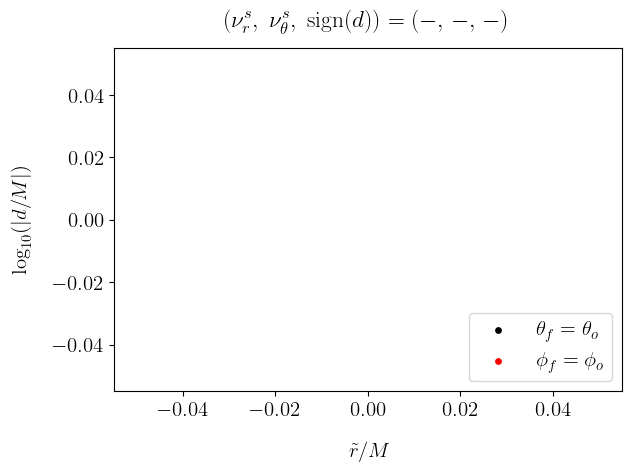

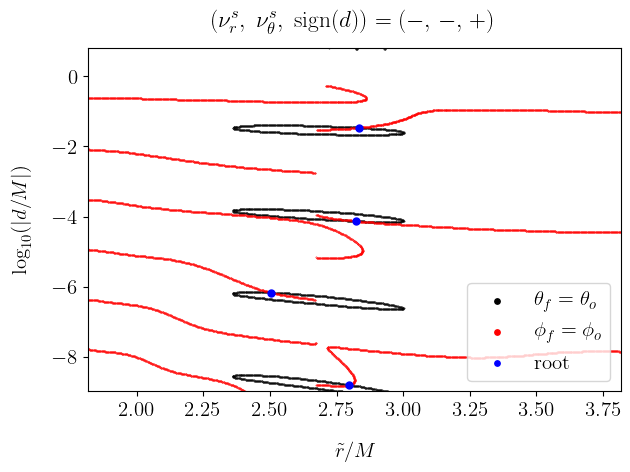

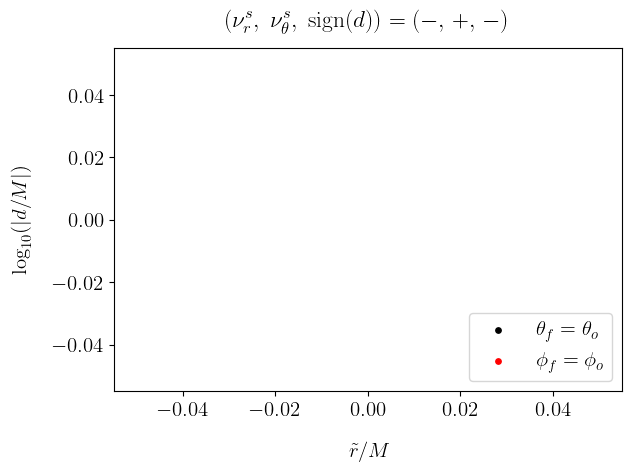

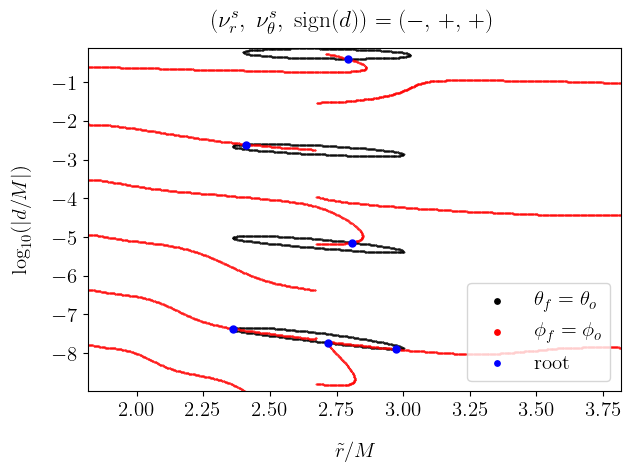

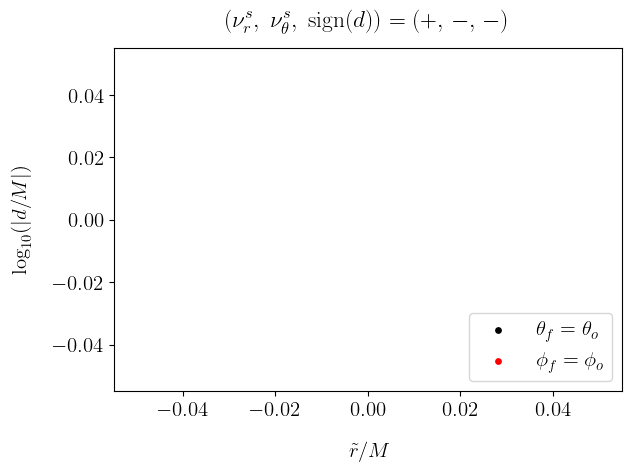

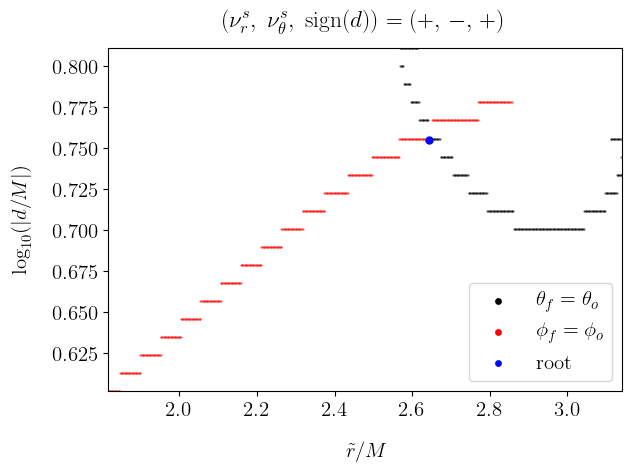

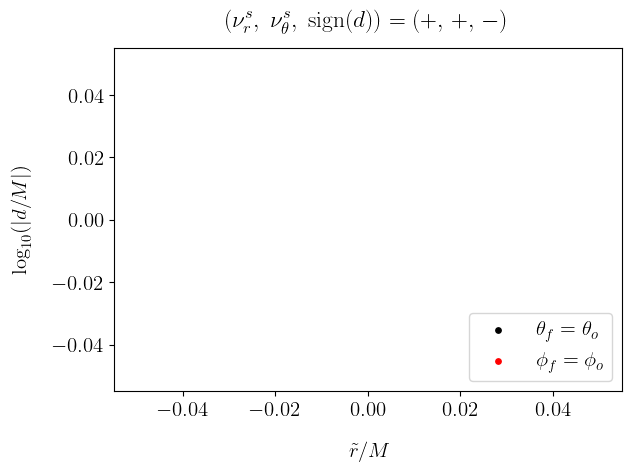

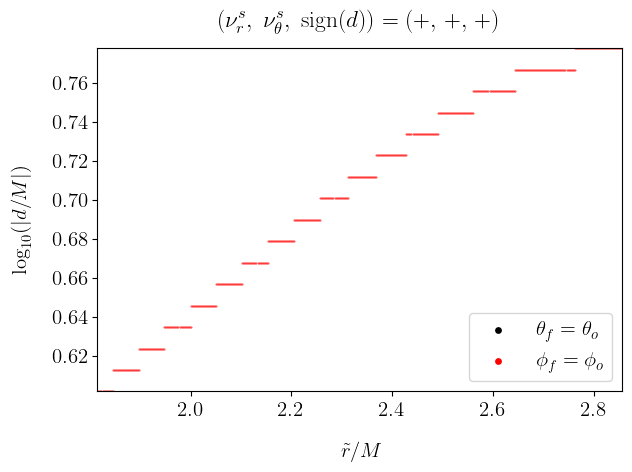

In [14]:
""" run over all combinations of [nu_r, nu_theta, d_sign] """
list_fig = []
list_solutions = []
for val_nu_r in [rt.Sign.NEGATIVE, rt.Sign.POSITIVE]:
    for val_nu_theta in [rt.Sign.NEGATIVE, rt.Sign.POSITIVE]:
        for val_d_sign in [rt.Sign.NEGATIVE, rt.Sign.POSITIVE]:

            ### set parameters
            pars = rt.ForwardRayTracingParamsFloat64()
            pars.a = 0.8
            pars.r_s = 10
            pars.theta_s = 89.9 * np.pi / 180
            pars.r_o = 1000
            theta_o = 17 * np.pi / 180
            phi_o = np.pi / 4
            pars.calc_t_f = True
            pars.nu_r = val_nu_r
            pars.nu_theta = val_nu_theta
            pars.d_sign = val_d_sign
            print("nu_r, nu_theta, d_sign:  ", sign_to_num(pars.nu_r), sign_to_num(pars.nu_theta), sign_to_num(pars.d_sign))
            
            ### sweep
            rc_l, rc_h = rc_range(pars.a)
            rc_size = 1000
            d_size = 1000
            rc_list = np.linspace(rc_l, rc_h, rc_size)
            lgdmin, lgdmax = (-9, 2)
            lgd_list = np.linspace(lgdmin, lgdmax, d_size)
            cutoff = 50
            tol = 1e-6
            pars.print_args_error = False
            data = rt.sweep_rc_d_Float64(pars, theta_o, phi_o, rc_list, lgd_list, cutoff, tol)    

            final_pars = []
            for i in range(len(data.results)):
                res = data.results[i]
                new_pars = {}
                new_pars["n"] = res.n_half
                new_pars["nu_r"] = pars.nu_r
                new_pars["nu_theta"] = pars.nu_theta
                new_pars["d_sign"] = pars.d_sign
                new_pars["rc"] = res.rc
                new_pars["log_abs_d"] = res.log_abs_d
                new_pars["lam"] = res.lam
                new_pars["eta"] = res.eta
                alpha, beta = conserve_to_ob(pars.a, res.lam, res.eta, theta_o, np.power(-1, res.m) * sign_to_num(pars.nu_theta))
                new_pars["al"] = alpha
                new_pars["be"] = beta
                new_pars["tf"] = res.t_f
                final_pars.append(new_pars)
            
            ### sort according to n
            final_pars=sorted(final_pars,key=lambda x:x["n"],reverse=False)
            list_solutions.extend(final_pars)
            
            ### plot
            fig, ax = plt.subplots(1,1)
            ax.scatter(data.theta_roots[:, 0], data.theta_roots[:, 1], s = 0.1, label = r"$\theta_f = \theta_o$")
            ax.scatter(data.phi_roots[:, 0], data.phi_roots[:, 1], s = 0.1, label = r"$\phi_f = \phi_o$")
            if len(final_pars)>0:
                final_pars = np.array(final_pars)
                list_rc = [par["rc"] for par in final_pars]
                list_log_abs_d = [par["log_abs_d"] for par in final_pars]
                ax.scatter(list_rc, list_log_abs_d, s = 25, marker = "o" , label = r"$\mathrm{root}$")
                
            ax.set_xlabel(r'$\tilde{r}/M$', labelpad=15)
            ax.set_ylabel(r'$\log_{10}(|d/M|)$', labelpad=15)
            ax.set_xmargin(0)
            ax.set_ymargin(0)
            sign_to_num_label = lambda x: "$+$" if x==rt.Sign.POSITIVE else "$-$"
            ax.set_title(r"$(\nu_r^s,\ \nu_{\theta}^s,\ \mathrm{sign}(d)) = ($"+ sign_to_num_label(val_nu_r) +"$,\ $"+ sign_to_num_label(val_nu_theta) + "$,\ $" + sign_to_num_label(val_d_sign) +"$)$", pad=15, fontsize = 17)
            for item in [ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels():
                item.set_fontsize(15)
                
            legend = ax.legend(fontsize=15, loc=4)
            for legend_handle in legend.legend_handles:
                legend_handle.set_sizes([15])
                
            fig.tight_layout(pad=1)
            list_fig.append(fig)

In [15]:
"""solutions"""
sorted(list_solutions, key=lambda x: x["n"], reverse=False)

[{'n': 0.432327671016569,
  'nu_r': <Sign.POSITIVE: 1>,
  'nu_theta': <Sign.NEGATIVE: -1>,
  'd_sign': <Sign.POSITIVE: 1>,
  'rc': 2.6440543647413453,
  'log_abs_d': 0.75511940136396,
  'lam': 2.177129240789963,
  'eta': 103.64796652547702,
  'al': -7.446443023118765,
  'be': -7.315985004306882,
  'tf': 1007.790078069387},
 {'n': 1.590695927252192,
  'nu_r': <Sign.NEGATIVE: -1>,
  'nu_theta': <Sign.POSITIVE: 1>,
  'd_sign': <Sign.POSITIVE: 1>,
  'rc': 2.791171836725608,
  'log_abs_d': -0.40272095655604634,
  'lam': -0.47163998303012783,
  'eta': 29.894967845373042,
  'al': 1.6131519412160473,
  'be': 5.300985281693792,
  'tf': 1037.3898567339015},
 {'n': 2.4168448978763633,
  'nu_r': <Sign.NEGATIVE: -1>,
  'nu_theta': <Sign.NEGATIVE: -1>,
  'd_sign': <Sign.POSITIVE: 1>,
  'rc': 2.8325565228927556,
  'log_abs_d': -1.470288519506353,
  'lam': -0.7507479210659008,
  'eta': 26.57232166396023,
  'al': 2.5677858320040015,
  'be': -4.596489100294064,
  'tf': 1050.660102999578},
 {'n': 3.44640

In [19]:
"""contour plots"""
for fig in list_fig: print(fig)

Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)


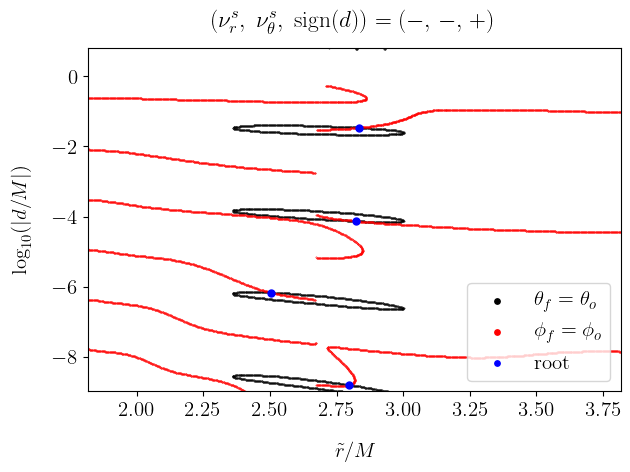

In [20]:
list_fig[1]

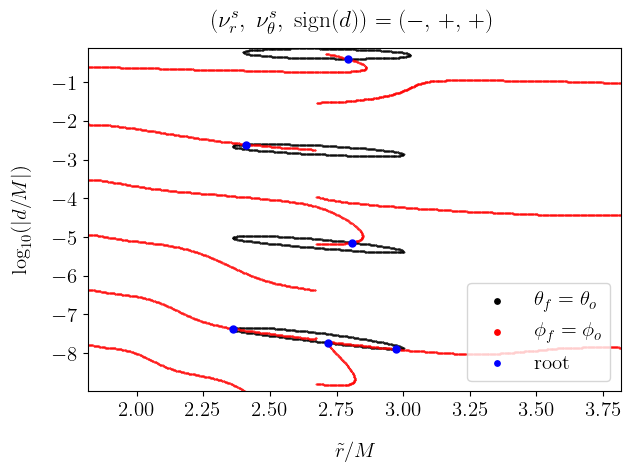

In [21]:
list_fig[3]

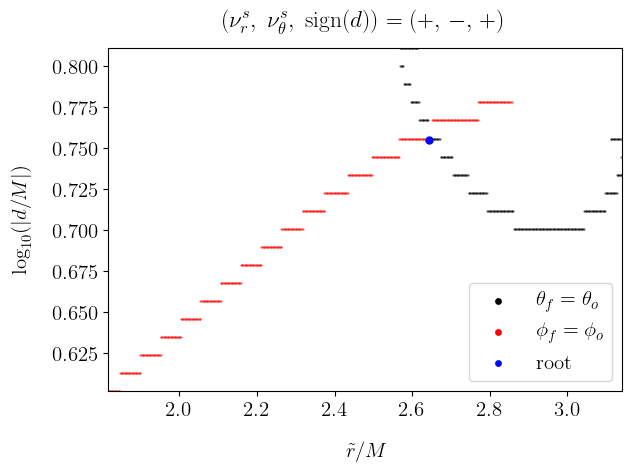

In [22]:
list_fig[5]

# Sweep with higher precision (Very Slow)

In [34]:
params = rt.ForwardRayTracingParams()
params.a = 0.8
params.r_s = 10
params.theta_s = 85 * np.pi / 180
params.r_o = 1000
params.nu_r = rt.Sign.NEGATIVE
params.nu_theta = rt.Sign.NEGATIVE
theta_o = 17 * np.pi / 180
phi_o = np.pi / 4

In [35]:
rc_l, rc_h = rc_range(0.8)
rc_size = 100
d_size = 100
total_size = rc_size * d_size
rc_list = np.linspace(rc_l, rc_h, rc_size)
lgd_list = np.linspace(-5, 2, d_size)
params.d_sign = rt.Sign.POSITIVE
d_list = np.power(10., lgd_list)
rc_x, lgd_y = np.meshgrid(rc_list, lgd_list)

In [ ]:
cutoff = 30
tol = 1e-10
data = rt.sweep_rc_d_high_Float64(params, theta_o, phi_o, rc_list, lgd_list, cutoff, tol)

ray status: R_OUT_OF_RANGE
ray status: R_OUT_OF_RANGE
ray status: R_OUT_OF_RANGE
ray status: R_OUT_OF_RANGE
ray status: R_OUT_OF_RANGE
ray status: R_OUT_OF_RANGE
ray status: R_OUT_OF_RANGE
ray status: R_OUT_OF_RANGE
ray status: R_OUT_OF_RANGE
ray status: R_OUT_OF_RANGE
ray status: R_OUT_OF_RANGE
ray status: R_OUT_OF_RANGE
find root failed, rc = 2.6993678219370647, log_abs_d = 0.7667667667667661, reason: residual > threshold: 0.24046772045197312 > 1e-06

ray status: R_OUT_OF_RANGE
ray status: R_OUT_OF_RANGE
ray status: R_OUT_OF_RANGE
ray status: R_OUT_OF_RANGE
ray status: R_OUT_OF_RANGE
ray status: R_OUT_OF_RANGE
find root failed, rc = 2.693338759666732, log_abs_d = 0.7667667667667661, reason: residual > threshold: 0.19067749137459877 > 1e-06

ray status: R_OUT_OF_RANGE
find root failed, rc = 2.6973581345136206, log_abs_d = 0.7667667667667661, reason: residual > threshold: 0.21715038680672918 > 1e-06

ray status: R_OUT_OF_RANGE
ray status: R_OUT_OF_RANGE
ray status: R_OUT_OF_RANGE
ray s

In [ ]:
final_params = np.zeros((len(data.results), 4))
for i in range(len(data.results)):
    final_params[i, 0] = data.results[i].rc
    final_params[i, 1] = data.results[i].log_abs_d
    final_params[i, 2] = data.results[i].lam
    final_params[i, 2] = data.results[i].eta
final_params